<a href="https://colab.research.google.com/github/Thanmaigottumukkala/Principles-of-Data-Science/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Set up the environment by installing packages, fixing conflicts, importing libraries, and downloading data needed for text preprocessing, topic modeling, and visualization.




In [1]:

import pandas as pd
import numpy as np
import nltk
import re
import string
import emoji
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import spacy
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

!pip install pyLDAvis
!pip install funcy

import pyLDAvis
import pyLDAvis.gensim_models

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#Step 2: Mount Google Drive to access dataset files directly in Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Step 3: Load dataset from Parquet, preview it, and save a copy as CSV for easier access and sharing.


In [3]:
# Read parquet
parquet_file_path = '/content/drive/MyDrive/nyt_data.parquet'
df = pd.read_parquet(parquet_file_path, engine='pyarrow')

# Print a few rows to check content
print("Sample Data from Parquet File:")
print(df.head())

# Save as CSV
csv_file_path = '/content/drive/MyDrive/nyt_data.csv'
df.to_csv(csv_file_path, index=False)


Sample Data from Parquet File:
   year                                              title  \
0  1920  At last the Federal Reserve Board has issued r...   
1  1920                            WILL TEST DOOR SERVICE.   
2  1920                    Sanction for Chinese Contracts.   
3  1920                            LEADS FRAZIER BY 4,496.   
4  1920  CHICAGO, April 30.--With 300 suspicious charac...   

                                             excerpt  
0                                                     
1  Service Board to Further Examine I.R.T. Safety...  
2                                                     
3  Langer's Margin Falls in North Dakota--Gronna ...  
4  Federal Agents and Police Round-- up Suspiciou...  


#Step 4: Print detailed information about the dataset, including its shape (rows and columns), column data types, and memory usage to understand its structure and optimize processing.


Dataset Overview:
Number of rows: 17370913
Number of columns: 3

Columns and Data Types:
year        int64
title      object
excerpt    object
dtype: object

Memory usage: 6.0328 GB


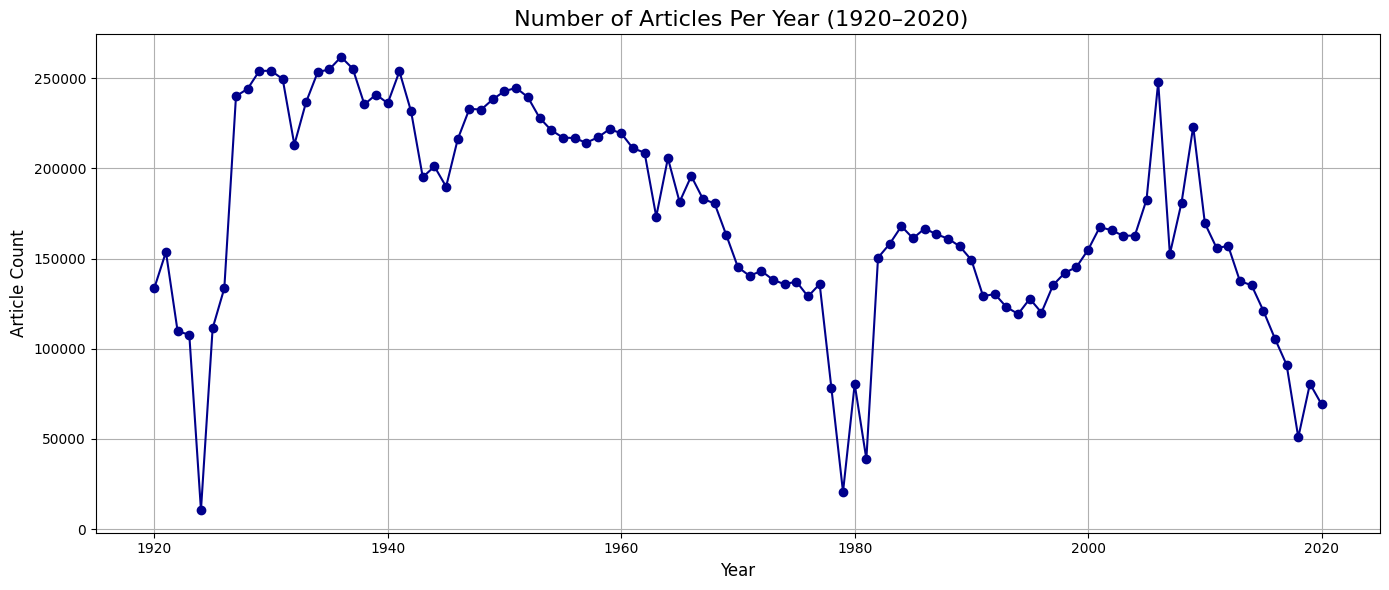

In [4]:
# Print detailed information about the dataset
print("Dataset Overview:")

# 1. Print the number of rows and columns
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# 2. Print the column names and their data types
print("\nColumns and Data Types:")
print(df.dtypes)

# 3. Print memory usage in GB
memory_usage = df.memory_usage(deep=True).sum() / (1024**3)  # Convert bytes to GB
print(f"\nMemory usage: {memory_usage:.4f} GB")

# Count articles per year
article_counts = df['year'].value_counts().sort_index()

# Plot line chart
plt.figure(figsize=(14, 6))
plt.plot(article_counts.index, article_counts.values, marker='o', color='darkblue')
plt.title(' Number of Articles Per Year (1920–2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Article Count', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 5: Read the CSV file in chunks to avoid memory issues with large files, then display the first chunk verify correct reading.


In [5]:
# Read the CSV in chunks
chunk_size = 5000  # Adjust based on available RAM
csv_file_path = '/content/drive/MyDrive/nyt_data.csv'

# Preview just the first chunk to check the structure
preview_chunk = next(pd.read_csv(csv_file_path, chunksize=chunk_size))
print("Preview of first chunk:")
print(preview_chunk.head())
print(preview_chunk.columns)


Preview of first chunk:
   year                                              title  \
0  1920  At last the Federal Reserve Board has issued r...   
1  1920                            WILL TEST DOOR SERVICE.   
2  1920                    Sanction for Chinese Contracts.   
3  1920                            LEADS FRAZIER BY 4,496.   
4  1920  CHICAGO, April 30.--With 300 suspicious charac...   

                                             excerpt  
0                                                NaN  
1  Service Board to Further Examine I.R.T. Safety...  
2                                                NaN  
3  Langer's Margin Falls in North Dakota--Gronna ...  
4  Federal Agents and Police Round-- up Suspiciou...  
Index(['year', 'title', 'excerpt'], dtype='object')


# Step 6: Efficiently preprocess a large CSV of text data in chunks using stemming and stopword removal, then save the cleaned output.




In [6]:

from nltk.stem import PorterStemmer


# Set up fast tools
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def fast_preprocess(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# File path and chunking
csv_file_path = '/content/drive/MyDrive/nyt_data.csv'
chunk_size = 250000  # Try a higher chunk size if RAM allows

processed_chunks = []
chunks = pd.read_csv(csv_file_path, chunksize=chunk_size)

for chunk in tqdm(chunks, desc="Processing Chunks"):
    chunk = chunk.dropna(subset=["excerpt"]).reset_index(drop=True)
    chunk['processed_text'] = chunk['excerpt'].apply(fast_preprocess)
    processed_chunks.append(chunk)

# Combine and save
processed_df = pd.concat(processed_chunks, ignore_index=True)
processed_df.to_csv("/content/drive/MyDrive/processed_data.csv", index=False)


Processing Chunks: 70it [45:12, 38.75s/it]


#Step 7: Converts cleaned text into numerical features using CountVectorizer for use in topic modeling or ML algorithms.

max_df=0.9 removes very frequent words.

min_df=10 keeps only words that appear in at least 10 documents.





In [7]:
# Vectorize the Text Data

vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(processed_df['processed_text'])

print("Vectorization complete. Shape of matrix:", X.shape)


Vectorization complete. Shape of matrix: (7965581, 105888)


#Step 8: Train an LDA model to discover hidden topics

You chose to extract 10 topics.

In [ ]:
#Train LDA Model (Topic Modeling)
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

print("LDA Model Training Complete")

# Assign Dominant Topic to Each Document

topic_distributions = lda.transform(X)
processed_df['dominant_topic'] = np.argmax(topic_distributions, axis=1)


#Step 9:  Time-Based Topic Trend Analysis

Assign the dominant topic to each document, group by year and topic to analyze trends, normalize the data, and plot the trends of each topic over time.



In [ ]:

# Group by year and topic
topic_year_trends = processed_df.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# Normalize the data
topic_year_trends_normalized = topic_year_trends.div(topic_year_trends.sum(axis=1), axis=0)

# Plot trends

plt.figure(figsize=(12, 6))
for topic in topic_year_trends_normalized.columns:
    plt.plot(topic_year_trends_normalized.index, topic_year_trends_normalized[topic], label=f'Topic {topic}')
plt.title('Topic Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Topic Proportion')
plt.legend()
plt.grid(True)
plt.show()



#Step 10: Save the cleaned DataFrame as a CSV file to Google Drive and confirm successful saving.


In [ ]:
#Save Cleaned CSV
processed_df.to_csv('/content/drive/MyDrive/nyt_data_cleaned.csv', index=False)
print("Cleaned CSV saved successfully!")


#Step 11: Model Evaluation: Prepare data in Gensim format and compute coherence score to evaluate the quality and interpretability of the LDA topics.


In [ ]:
# Prepare data for gensim
texts = [doc.split() for doc in processed_df['processed_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

from gensim.models import LdaModel

lda_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=10, random_state=42)
coherence_model = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score:.4f}")


#Step 12: Displays top 10 words for each topic and helps understand what each topic is talking about.




In [ ]:
# Display Top Words per Topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


#Step 13:  Generate and display a word cloud for each topic to visually highlight its most important words.


In [ ]:
# Visualize Topics with WordClouds

for idx, topic in enumerate(lda.components_):
    plt.figure()
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(
        {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[:-50 - 1:-1]}
    )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {idx + 1}')
    plt.show()


#Step 14: Generate and save an interactive HTML visualization of the LDA topics using pyLDAvis.


In [ ]:
# Interactive Visualization with pyLDAvis

pyLDAvis.save_html(pyLDAvis.sklearn.prepare(lda, X, vectorizer), '/content/drive/MyDrive/lda_vis.html')


## NMF Model

# Train the NMF Model


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer (you can also use TfidfVectorizer here)
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')

# Vectorize the processed text
X = vectorizer.fit_transform(processed_df['processed_text'])

print(f"Shape of the document-term matrix: {X.shape}")


In [ ]:
# Train NMF Model (Topic Modeling)
from sklearn.decomposition import NMF

n_topics = 10  # Define the number of topics you want
nmf = NMF(n_components=n_topics, random_state=42)
nmf.fit(X)

print("✅ NMF Model Training Complete")


# Evaluate with Gensim Coherence Score

In [ ]:
# Prepare data for Gensim (same as LDA)
texts = [doc.split() for doc in processed_df['processed_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Convert sklearn NMF model to Gensim format (for evaluation)
topics_nmf = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in nmf.components_]

# Evaluate NMF with Gensim Coherence Score
coherence_model_nmf = CoherenceModel(topics=topics_nmf, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score_nmf = coherence_model_nmf.get_coherence()

print(f"🧪 NMF Coherence Score: {coherence_score_nmf:.4f}")


#  Display Top Words per Topic for NMF

In [ ]:
# Display top words per topic
def display_topics_nmf(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

# Display top 10 words for each topic
no_top_words = 10
display_topics_nmf(nmf, vectorizer.get_feature_names_out(), no_top_words)


# Visualize Topics with WordClouds for NMF

In [ ]:
# Visualize topics with WordClouds
for idx, topic in enumerate(nmf.components_):
    plt.figure()
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(
        {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[:-50 - 1:-1]}
    )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {idx + 1}')
    plt.show()


# Interactive Visualization with pyLDAvis for NMF

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

# Interactive visualization with pyLDAvis
# For NMF, the pyLDAvis.sklearn function works similarly to LDA
pyLDAvis.save_html(pyLDAvis.sklearn.prepare(nmf, X, vectorizer), '/content/drive/MyDrive/nmf_vis.html')



Install libraries ----Set up your working environment

Mount Drive ----Access dataset

Convert parquet → csv	----Make handling easier

Chunk loading	----Avoid RAM crash

Preprocessing	----Clean text

Combine data	----Merge cleaned chunks

Save clean CSV	----Avoid repeating preprocessing

Vectorization	----Numerical representation of text

Topic modeling	----Extract hidden topics

Visualization	----Understand topics with WordClouds